In [1]:
#%% solve the Helmoltz equation with Hard-constrain DNN
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

## Environment preparing
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
#%% solve the Helmoltz equation with Hard-constrain DNN
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

## Environment preparing
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
#%% PINN network
class PINN(nn.Module):
    def __init__(self,in_dim, h_dim, out_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim,h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim,h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            # nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim,h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim, h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim, h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim, h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim, h_dim),
            nn.SiLU(),
            #torch.nn.BatchNorm1d(30, momentum=0.5),
            #nn.Softplus(beta=1, threshold=20),
            nn.Linear(h_dim, out_dim),
        )
    def forward(self, x):
        out = self.model(x)
        return out


In [15]:
## define loss function
# loss for Neuman boundary constraint
def loss_Neuman(model_pr,X_bd,Normal_ij,g_ij,be_ij,grad_be_ij,grad_al_ij):
    # X_ij = [vec(r),vec(z)] in tensor[N,2]
    # Normal_ij means the normal vector of boundary
    # pn_ij: true value in boundary; be_ij/grad_be_ij/grad_al_ij: constuct function/its grad
    y_ij_r = model_pr(X_bd)
    print(X_bd.shape)
    y_ij_grad_r = torch.autograd.grad(
        y_ij_r,X_bd,
        grad_outputs=torch.ones_like(y_ij_r),
        retain_graph=True,
        create_graph=True
    )[0]
    yr_ij_r = y_ij_grad_r[:,0:1]
    yz_ij_r = y_ij_grad_r[:,1:2]

    normal_r = Normal_ij[:,0:1]
    normal_z = Normal_ij[:,1:2]
    print(Normal_ij.shape)

    print(g_ij.shape)

    tilde_p_ne = normal_r*((yr_ij_r*be_ij + grad_be_ij[:,0:1]*y_ij_r)+grad_al_ij[:,0:1]) + \
        normal_z*((yz_ij_r*be_ij + grad_be_ij[:,1:2]) + grad_al_ij[:,1:2])
    loss_Ne = torch.mean((tilde_p_ne-g_ij)**2)
    
    return loss_Ne

# loss for data_res constraint
def loss_res_p(model_pr,X_ij,t_p_ij,al_ij,be_ij):
    # t_p_ij means the true value of p
    p_ij_r = model_pr(X_ij)
    loss_res = torch.mean((t_p_ij - (p_ij_r*be_ij+al_ij))**2)
    return loss_res

def loss_equation(model_pr,X_ij,al_ij,be_ij,k,q_ij,\
                  grad_al_ij,grad_be_ij,grad_grad_al_ij,grad_grad_be_ij):
    # assume grad_grad_al_ij -> a_rr a_rz a_zr a_zz
    # q_ij is Non-homogeneous term
    y_ij_r = model_pr(X_ij)

    y_ij_grad_r = torch.autograd.grad(
        y_ij_r,X_ij,
        grad_outputs=torch.ones_like(y_ij_r),
        retain_graph=True,
        create_graph=True
    )[0] # yre_r yre_z

    yr_ij_r = y_ij_grad_r[:,0:1]
    yz_ij_r = y_ij_grad_r[:,1:2]
    y_drdX_r = torch.autograd.grad(
        yr_ij_r,X_ij,
        grad_outputs=torch.ones_like(yr_ij_r),
        retain_graph=True,
        create_graph=True
    )[0] # y_rr y_rz
    y_dzdX_r = torch.autograd.grad(
        yz_ij_r,X_ij,
        grad_outputs=torch.ones_like(yz_ij_r),
        retain_graph=True,
        create_graph=True
    )[0] # y_zr y_zz
    yrr_ij_r = y_drdX_r[:,0:1] # y_rr_r
    yzz_ij_r = y_dzdX_r[:,1:2] # y_zz_r
    # print(yrr_ij_r)
    tilde_p_rr = grad_grad_al_ij[:,0:1] + 2*grad_be_ij[:,0:1]*yr_ij_r + \
        grad_grad_be_ij[:,0:1]*y_ij_r + yrr_ij_r*be_ij # a_rr + 2b_ry_r + b_rr + y_rr
    tilde_p_r = 1/X_ij[:,0:1]*(grad_al_ij[:,0:1] + grad_be_ij[:,0:1]*y_ij_r + be_ij*yr_ij_r) # (a_r + b_r y + y_r b)/r
    tilde_p_zz = grad_grad_al_ij[:,1:2] + 2*grad_be_ij[:,1:2]*yz_ij_r + \
        grad_grad_be_ij[:,1:2]*y_ij_r + yzz_ij_r*be_ij     # a_zz + 2b_z y_z + y_zz b + b_zz y
    tilde_p = al_ij + be_ij*y_ij_r
    loss_eq = torch.mean((tilde_p_rr + tilde_p_r + tilde_p_zz + k**2*tilde_p - q_ij)**2)
    return loss_eq

def loss_total_p(model_pr,X_ij,X_bound,t_p_ij,al_ij,be_ij,Normal_bound,g_ij,lambda_k,\
                 k,q_ij,grad_al_ij,grad_be_ij,grad_grad_al_ij,grad_grad_be_ij,\
                 g_bound,be_bound,grad_be_bound,grad_al_bound):
    # lambda_k: penalty issue
    loss_res = loss_res_p(model_pr,X_ij,t_p_ij,al_ij,be_ij)
    loss_Ne = loss_Neuman(model_pr,X_bound,Normal_bound,g_bound,be_bound,grad_be_bound,grad_al_bound)
    loss_eq = loss_equation(model_pr,X_ij,al_ij,be_ij,k,q_ij,\
                  grad_al_ij,grad_be_ij,grad_grad_al_ij,grad_grad_be_ij)
    loss_total = loss_eq + loss_res + loss_Ne/3
    return loss_total,loss_Ne,loss_res,loss_eq

In [5]:
## define g,h,alpha(al),beta(be),q and its grad
p0 = 0.5   # reference pressure
H = 100     # heigh of sea
zs = 20
c = 1500
f = 300
k = f*2*np.pi/c
# the function using now has maximum value f(0.377H) = 0.052H^4
def al(r,z,k):
    al_ij = p0*z**2*(2*z - 3*H)/H**3 
    # print(al_ij)
    return al_ij

def be(r,z,k):
    be_ij = p0*z**2*(2*z - 3*H)/H**3
    return be_ij

def grad_al(r,z,k):
    al_r = 0.0 * r
    al_z = p0 * (6*z**2 - 6*z*H)/H**3
    # grad_al_ij = torch.empty(list(r.size())[0],2)
    # grad_al_ij[:,0] = 0.0*r
    # grad_al_ij[:,1] = p0*(z-H)
    return np.hstack([al_r,al_z])

def grad_be(r,z,k):
    be_r = 0.0 * r
    be_z = p0 * (6*z**2 - 6*z*H)/H**3
    # grad_be_ij = torch.empty(list(r.size())[0],2)
    # grad_be_ij[:,0] = 0.0*r
    # grad_be_ij[:,1] = p0*(z-H)
    return np.hstack([be_r,be_z])

def grad_grad_al(r,z,k):
    al_rr = 0.0 * r
    al_zz = p0 * (12*z - 6*H)/H**3
    # grad_grad_al_ij = torch.empty(list(r.size())[0],4)
    # grad_grad_al_ij[:,0] = 0.0*r
    # grad_grad_al_ij[:,1] = 0.0*r
    # grad_grad_al_ij[:,2] = 0.0*r
    # grad_grad_al_ij[:,3] = p0
    return np.hstack([al_rr, al_zz])

def grad_grad_be(r,z,k):
    be_rr = 0.0 * r
    be_zz = p0 * (12*z - 6*H)/H**3
    # grad_grad_be_ij = torch.empty(list(r.size())[0],4)
    # grad_grad_be_ij[:,0] = 0.0*r
    # grad_grad_be_ij[:,1] = 0.0*r
    # grad_grad_be_ij[:,2] = 0.0*r
    # grad_grad_be_ij[:,3] = p0
    return np.hstack([be_rr, be_zz])

def Normal_vec(r,z,k):
    # for flat bottom
    # Normal_vec_ij = torch.empty(list(r.size())[0],2)
    # Normal_vec_ij[:,0] = 0.0*r
    # Normal_vec_ij[:,1] = 1.0*r
    N_r = 0.0 * r
    N_z = 1.0 * np.ones_like(r)
    # for clien bottom (0,H) (R,B)
    # R = 1000
    # B = 10
    # Normal_vec_ij[:,0] = -B/R*r
    # Normal_vec_ij[:,1] = 1.0*r
    return np.hstack([N_r,N_z])

def q(r,z,k):
    # delta(z-zs)delta(r)
    q_ij = 0.0 * r
    q_ij[r == 0 & z == zs] = 1
    return q_ij

In [6]:
#%% initial training data using K
import pandas as pd
import numpy as np
import torch
import random

random.seed()

# read data from csv,z in[1001,1] r in [1000,1] p in [1001,1000]
r_d = pd.read_csv('data/K_300_r.csv')['r']
r_d = torch.tensor(r_d).reshape(-1,1)
z_d = pd.read_csv('data/K_300_z.csv')['z']
z_d = torch.tensor(z_d).reshape(-1,1)
l = list(np.linspace(0, 1, 200))
p_d_i = pd.read_csv('data/K_300_pi.csv',names=l)[l].values
p_d_r = pd.read_csv('data/K_300_pr.csv',names=l)[l].values
p_d_r = p_d_r.astype(np.float32)
p_d_i = p_d_i.astype(np.float32)
#p_d_r = np.transpose(p_d_r)
#p_d_i = np.transpose(p_d_i)

# Density of grid points(inner)
# N_inner = 2000
# random_r = list(np.random.randint(1,999,N_inner)) # get points inner, except z = H/0
# random_z = list(np.random.randint(1,999,N_inner))
# r = r_d[random_r,0:1].numpy()
# z = z_d[random_z,0:1].numpy()
r,z = np.meshgrid(r_d[1:200], z_d[0:100])
r = r.reshape(100*199,1)
z = z.reshape(100*199,1)
X_ij = np.hstack([r,z]) # [[r[0:199],0],[r[0:199],1],...,]
X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
# r = X_ij[:,0:1]
# z = X_ij[:,1:2]

# list_z = list(np.linspace(0,99,100))
# Get pressure data
pd_r_ij = p_d_r[0:100,1:200]
pd_i_ij = p_d_i[0:100,1:200]
pd_r_ij = pd_r_ij.reshape(100*199,1)
pd_i_ij = pd_i_ij.reshape(100*199,1)
print(r)
print(pd_r_ij)
pd_r_ij = torch.from_numpy(pd_r_ij).double().to(device)
pd_i_ij = torch.from_numpy(pd_i_ij).double().to(device)
pd_ij = torch.complex(pd_r_ij,pd_i_ij).to(device)
# print(p_d_i[0,1])
# pd_ij = np.hstack(pd_r_ij+1j*pd_i_ij)
# pd_r_ij = pd_ij[:,0:1]
# pd_i_ij = pd_ij[:,1:2]
# x = torch.complex(torch.tensor([1.0, 2.0]), torch.tensor([3.0, 4.0]))

# Get boundary data
N_bound = 100
random_r_bo = random.sample(range(0,199), N_bound)
random_z_bo = 100*np.ones(N_bound)
r_bound = r_d[random_r_bo,0:1].numpy()
z_bound = z_d[random_z_bo,0:1].numpy()
X_bound = np.hstack([r_bound,z_bound])
X_bound = torch.from_numpy(X_bound).requires_grad_(True).double().to(device)
# Get boundary pressure

# Get other funtions' value/grad
al_ij = al(r,z,k)
be_ij = be(r,z,k)
grad_al_ij = grad_al(r,z,k)
grad_be_ij = grad_be(r,z,k)
grad_grad_al_ij = grad_grad_al(r,z,k)
grad_grad_be_ij = grad_grad_be(r,z,k)
norm_vec_bound = Normal_vec(r_bound,z_bound,k)
g_bound = 0.0 * r_bound
be_bound = be(r_bound,z_bound,k)
grad_be_bound = grad_be(r_bound,z_bound,k)
grad_al_bound = grad_al(r_bound,z_bound,k)
q_ij = 0.0 * r
g_ij = 0.0 * r
# q_ij[z==zs & r == 0] = 1


[[  1.00502515]
 [  2.0100503 ]
 [  3.01507544]
 ...
 [197.9899445 ]
 [198.9949799 ]
 [200.        ]]
[[ 7.0500001e-15]
 [-5.5100001e-15]
 [-4.4700000e-15]
 ...
 [-2.6805490e-02]
 [-4.7217552e-03]
 [ 2.3267288e-02]]


In [7]:
g_ij.shape

(19900, 1)

In [8]:
# translate to tensor
al_ij = torch.from_numpy(al_ij).double().to(device)
be_ij = torch.from_numpy(be_ij).double().to(device)
grad_al_ij = torch.from_numpy(grad_al_ij).double().to(device)
grad_be_ij = torch.from_numpy(grad_be_ij).double().to(device)
grad_grad_al_ij = torch.from_numpy(grad_grad_al_ij).double().to(device)
grad_grad_be_ij = torch.from_numpy(grad_grad_be_ij).double().to(device)
norm_vec_bound = torch.from_numpy(norm_vec_bound).double().to(device)
q_ij = torch.from_numpy(q_ij).double().to(device)
g_ij = torch.from_numpy(g_ij).double().to(device)
g_bound = torch.from_numpy(g_bound).double().to(device)
be_bound = torch.from_numpy(be_bound).double().to(device)
grad_be_bound = torch.from_numpy(grad_be_bound).double().to(device)
grad_al_bound = torch.from_numpy(grad_al_bound).double().to(device)
# translate to complex
# al_ij = torch.complex(al_ij,torch.zeros_like(al_ij))
# be_ij = torch.complex(be_ij,torch.zeros_like(be_ij))
# grad_al_ij = torch.complex(grad_al_ij,torch.zeros_like(grad_al_ij))
# grad_be_ij = torch.complex(grad_be_ij,torch.zeros_like(grad_be_ij))
# grad_grad_be_ij = torch.complex(grad_grad_be_ij,torch.zeros_like(grad_grad_be_ij))
# grad_grad_al_ij = torch.complex(grad_grad_al_ij,torch.zeros_like(grad_grad_al_ij))
# q_ij = torch.complex(q_ij,torch.zeros_like(q_ij))
# g_ij = torch.complex(g_ij,torch.zeros_like(g_ij))

In [9]:
# Model, opt, learning rates, palnaty

model_pr = PINN(2,64,1).to(device)
model_pi = PINN(2,64,1).to(device)
print(model_pr)
print(model_pi)

# model_p.model1.weight.grad = torch.complex(model_p.model1.weight.grad, torch.zeros_like(model_p.model1.weight.grad))
# model_p.model1.bias.grad = torch.complex(model_p.model1.bias.grad, torch.zeros_like(model_p.model1.bias.grad))

optimizer_r = torch.optim.Adam(
    list(model_pr.parameters()),
    lr = 0.001
)

optimizer_i = torch.optim.Adam(
    list(model_pi.parameters()),
    lr = 0.001
)

lambda_k = 1.00015
max_iter = 2000
def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 1000
    update_lr_2 = 2000
    update_lr_3 = 10000
    update_lr_4 = 15000
    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001
    if step == update_lr_4:
        for g in optimizer.param_groups:
            g['lr'] = 0.00003



PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): SiLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): SiLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): SiLU()
    (14): Linear(in_features=64, out_features=1, bias=True)
  )
)
PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_fe

In [10]:
# Training real part
model_pr.train()

loss_hist_r = []
pbar = trange(max_iter)

for step in pbar:
    lr_adjust(step, optimizer_r)
    optimizer_r.zero_grad()

    loss_total_r,loss_Ne_r,loss_res_r,loss_eq_r \
          = loss_total_p(model_pr,X_ij,X_bound,pd_r_ij,al_ij,be_ij,norm_vec_bound,g_ij,lambda_k,\
                 k,q_ij,grad_al_ij,grad_be_ij,grad_grad_al_ij,grad_grad_be_ij,\
                    g_bound,be_bound,grad_be_bound,grad_al_bound)
    loss_total_r.backward()
    optimizer_r.step()
    
    if step % 100 == 0:
        pbar.set_postfix({
            'loss': '{0:.5e}'.format(loss_total_r.item()),
                          'loss_Ne': '{0:.5e}'.format(loss_Ne_r.item()),
                          'loss_res': '{0:.5e}'.format(loss_res_r.item()),
                          'loss_eq': '{0:.5e}'.format(loss_eq_r.item()),
                          'stepsize': '{0:.5e}'.format(optimizer_r.param_groups[0]['lr'])
        })
        loss_hist_r.append(loss_total_r.item())
    

  1%|          | 15/2000 [00:12<26:47,  1.23it/s, loss=2.69770e-01, loss_Ne=4.01064e-08, loss_res=7.76985e-02, loss_eq=1.92072e-01, stepsize=1.00000e-03]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_hist_r, 'b')
ax.set_yscale('log')
plt.show()

In [16]:
model_pi.train()

loss_hist_i = []
pbar = trange(1)

for step in pbar:
    # lr_adjust(step, optimizer_r)
    lr_adjust(step, optimizer_i)
    optimizer_i.zero_grad()

    loss_total_i,loss_Ne_i,loss_res_i,loss_eq_i \
          = loss_total_p(model_pi,X_ij,X_bound,pd_i_ij,al_ij,be_ij,norm_vec_bound,g_ij,lambda_k,\
                 k,q_ij,grad_al_ij,grad_be_ij,grad_grad_al_ij,grad_grad_be_ij,\
                    g_bound,be_bound,grad_be_bound,grad_al_bound)
    loss_total_i.backward()
    optimizer_i.step()
    
    if step % 100 == 0:
        pbar.set_postfix({
            'loss': '{0:.5e}'.format(loss_total_i.item()),
                          'loss_Ne': '{0:.5e}'.format(loss_Ne_i.item()),
                          'loss_res': '{0:.5e}'.format(loss_res_i.item()),
                          'loss_eq': '{0:.5e}'.format(loss_eq_i.item()),
                          'stepsize': '{0:.5e}'.format(optimizer_i.param_groups[0]['lr'])
        })
        loss_hist_i.append(loss_total_i.item())

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 1])


100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=2.22669e-01, loss_Ne=2.45028e-07, loss_res=6.43146e-02, loss_eq=1.58354e-01, stepsize=1.00000e-03]


In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_hist_i, 'b')
ax.set_yscale('log')
plt.show()

tensor(-0.0501, grad_fn=<MeanBackward0>)


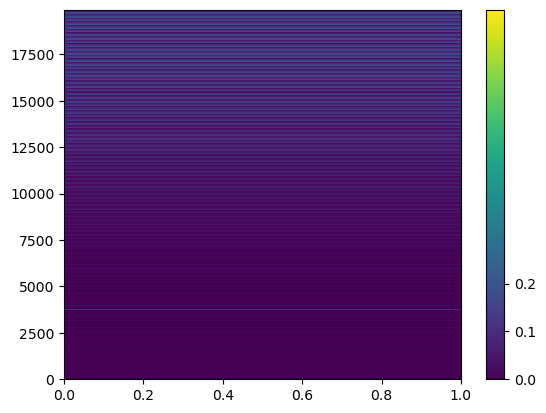

In [17]:
y_train_r = model_pr(X_ij)
y_train_i = model_pi(X_ij)
p_train_r = al_ij + be_ij*y_train_r
p_train_i = al_ij + be_ij*y_train_i
p_train = p_train_r + 1j*p_train_i

er_train = p_train_r - pd_r_ij
ei_train = p_train_i - pd_i_ij

print(torch.mean(er_train))

p = plt.pcolor((ei_train**2).detach().numpy())
plt.colorbar(ticks = [0,0.1,0.2])


In [ ]:
# import numpy as np
N_test = 1000*1001
r_mesh,z_mesh = np.meshgrid(r_d, z_d)
r_mesh_r = r_mesh.reshape(N_test,1)
z_mesh_r = z_mesh.reshape(N_test,1)
X_test = np.hstack([r_mesh_r,z_mesh_r])
X_test = torch.tensor(X_test)

# get al and be
al_test = al(r_mesh_r,z_mesh_r,k)
be_test = be(r_mesh_r,z_mesh_r,k)

y_test_r = model_pr(X_test).detach().cpu().numpy()
y_test_i = model_pi(X_test).detach().cpu().numpy()
p_test_r = al_test + be_test*y_test_r
p_test_i = al_test + be_test*y_test_i

# print(p_d_i.reshape(N_test,1))
p_test = p_test_i*1j + p_test_r
TL_test = -20*np.log10(np.abs(p_test))
TL_test = TL_test.reshape(1000,1001)

# get errors
p_true = p_d_r + 1j*p_d_i
TL_true = -10*np.log10(np.abs(p_true))
error_all_TL = TL_test - TL_true
error_all_p = p_true - p_test.reshape(1000,1001)
error_av = np.mean(error_all_TL)
# print(np.abs(error_all_p))
# print(np.mean(np.abs(error_all_TL)))
# print(error_all)
# print(error_av)

In [ ]:
from PIL import Image
p = plt.pcolor(np.abs(error_all_p))
clb = plt.colorbar(p)

'''
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_eu = ax.pcolormesh(r_d, z_d, TL_test, cmap=cm.coolwarm, linewidth=0.2)
surf_eu.set_edgecolors("black")
ax.title.set_text('Exact control')
fig.colorbar(surf_eu, shrink=0.5, aspect=5)
plt.show()
'''

In [ ]:
print(al_test)
